# Using the _Herschel_-SPIRE Point Source Catalogue: demo \# 2

This simple notebook demonstrates a simple use of the SPIRE Point Source Catalogue (SPSC). The user provides source coordinates and the script will loop over all OBSIDs where potentially the source may be and download the three SPIRE level-2 images for each band 250, 350 and 500 µm (mnemonic names `PSW`, `PMW` and `PLW` respectively) and will overlay the objects from the catalogue and optionally the sources from the initial source table, zoomed in (1x1 arcmin box).

**Required python packages:** `python 3.6` and above and in addition to the standard `numpy`, `matplotlib` you need `astropy`, and [`spherical_geometry`](https://github.com/spacetelescope/spherical_geometry) (can be installed with `pip`).

In [1]:
import os
import sys
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bmh')

from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy.nddata import Cutout2D

from astropy import units as u
from astropy.coordinates import SkyCoord

sys.path.append(os.getcwd())

from getSpirePhotMaps import getSpirePhotMaps
from whereis import whereis
from checkCoverage import check_coverage

## Some utility functions which will be needed

1. `getSpirePhotMaps()`: will download level-2 SPIRE maps from the [_Herschel_ Science Archive](http://archives.esac.esa.int/hsa/whsa/)
2. `whereis()`: will identify a list of OBSIDs where a point may lie within the 4-corners of the image footprint. Needs a `astropy.table.Table` object with columns "obsid,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4".
3. `check_coverage`: will calculate the average coverage in a 3x3 box centred on the source. 

Both `whereis()` and `check_coverage` are used to identify an OBSID which contains the input (ra,dec) coordinates and has non-zero coverage.


## The main body of the notebook

In [2]:
#
# set up the URL in Herschel legacy where all the products reside
#
legacy_url = 'https://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-P/SPSC'

In [3]:
spire_bands = ["PSW","PMW","PLW"]
#
# coordinates of a source in question
#
ra_c = 17.43504
dec_c = 35.62010
source = SkyCoord(ra=ra_c * u.deg, dec=dec_c * u.deg, frame='icrs') 
#
# next we load the footprints and identify OBSIDs where potentially the source may be in
#
footprints = Table.read(f'{legacy_url}/.release2/fourcorners_db.csv')
#
obsid_list = whereis(ra_c,dec_c,footprints)
nobs = len(obsid_list)
print (f"The point (RA, Dec)=({ra_c}, {dec_c}) deg is _potentially_ in {nobs} observations.")
#

/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/numeric.py:553: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/spherical_geometry/polygon.py:590: RuntimeWarning: invalid value encountered in triple_product
  orient = great_circle_arc.triple_product(A-B, C-B, B)
/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/spherical_geometry/polygon.py:133: RuntimeWarning: invalid value encountered in triple_product
  orient = great_circle_arc.triple_product(A-B, C-B, B)


The point (RA, Dec)=(17.43504, 35.6201) deg is _potentially_ in 11 observations.


In [4]:
#
# set the Tmp where the archive .tar file will be stored
#
myTmp = os.path.join(os.path.expanduser('~'),"Tmp","HerschelData")
if (not os.path.isdir(myTmp)):
    print ("Temporary folder must exist! Please set it ip to point to an already existsing folder on your disk.")
    raise FileNotFountError

#
# download the maps, hmaps will be a dictionary of FITS HDUs with keys "PSW", "PMW" and "PLW"
#
# now loop over the obsid_list and once we found a map where the coverage is greater than 0 then we stop
#
for xobsid in obsid_list:
    hmaps = getSpirePhotMaps(xobsid,tmpDir=myTmp)
    covc = check_coverage(ra_c,dec_c,hmaps['PSW'])
    if (covc > 0.0):
        obsid = xobsid
        break
#    
target = hmaps['PSW'][0].header['OBJECT']

Found an already existing tar file for OBSID 1342212366. Will use it


In [5]:
#
# now read the catalogue and sources
#
cats_dir = f'{legacy_url}/.release2/cats'
cat = {}
src = {}
for band in spire_bands:
    cat[band] = Table.read(f'{cats_dir}/{obsid}_{band}_catalog_sources.csv.gz',format='ascii.csv')
    src[band] = Table.read(f'{cats_dir}/{obsid}_{band}_sources.csv.gz',format='ascii.csv')
    print ("Found {} catalog entries for {}, band {}".format(len(cat[band]),obsid,band))
    print ("Found {} sources for {}, band {}".format(len(src[band]),obsid,band))#

Found 164 catalog entries for 1342212366, band PSW
Found 966 sources for 1342212366, band PSW
Found 121 catalog entries for 1342212366, band PMW
Found 816 sources for 1342212366, band PMW
Found 46 catalog entries for 1342212366, band PLW
Found 290 sources for 1342212366, band PLW


  gid             spscid          arrayname   flux  fluxerr
------- ------------------------- --------- ------- -------
2604564 HSPSC250B_J0109.73+3537.2       PSW 460.415  2.0074
2604544 HSPSC250B_J0109.68+3537.0       PSW 27.6253 1.89993
2604531 HSPSC250B_J0109.71+3536.6       PSW 23.5085 1.94313
3417776 HSPSC250B_J0109.69+3537.9       PSW 20.1648 2.36784
  gid             spscid          arrayname   flux  fluxerr
------- ------------------------- --------- ------- -------
2604557 HSPSC350B_J0109.73+3537.2       PMW  225.71 3.36454
2604462 HSPSC350B_J0109.69+3537.9       PMW 24.9327 2.21305
  gid             spscid          arrayname   flux  fluxerr
------- ------------------------- --------- ------- -------
2604542 HSPSC500B_J0109.73+3537.1       PLW 115.858   2.395


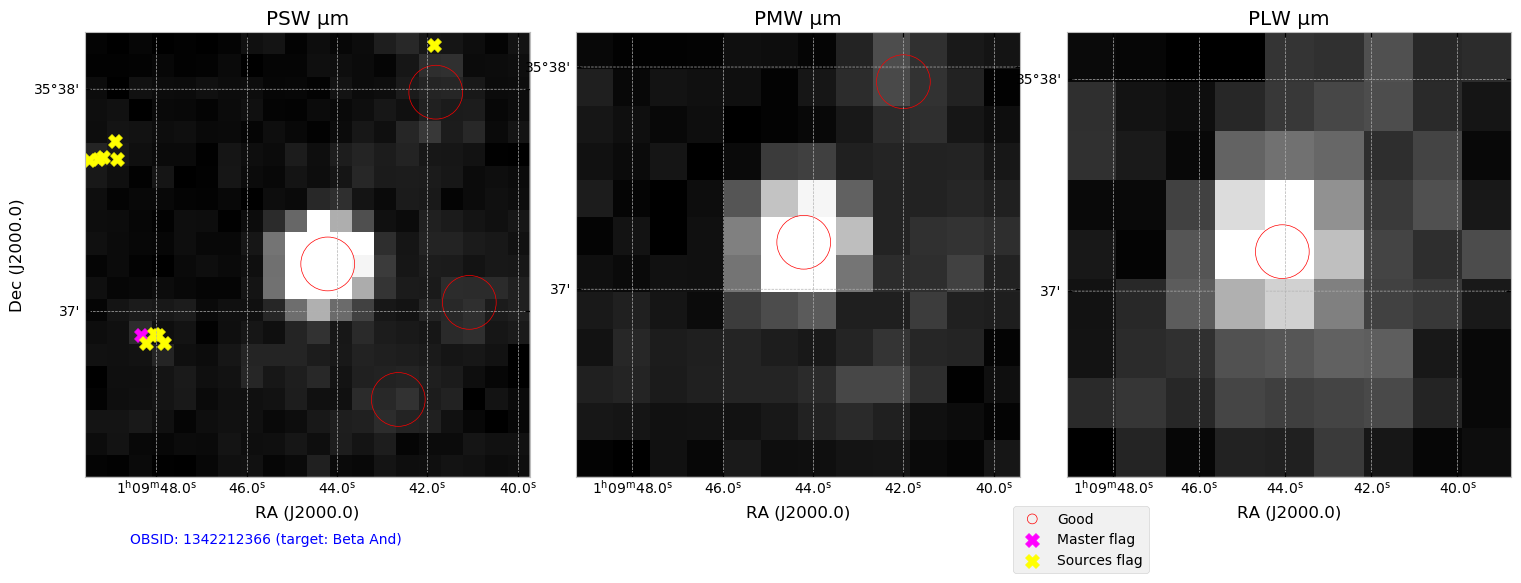

In [6]:
#
# plot the maps and the sources
#
#
fwhm = {'PSW': 18.0, 'PMW': 25.0, 'PLW': 36.0}
zx = 2.0
zoomSize = u.Quantity((zx,zx ), u.arcmin)
#
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 95.0 # 
for k,band in enumerate(spire_bands):
    ximage = hmaps[band]['image']
    wcs = WCS(hmaps[band]['image'].header)
    #norm = ImageNormalize(ximage.data[~np.isnan(ximage.data)], interval=PercentileInterval(pp))
    #
    cutout = Cutout2D(ximage.data, source, zoomSize, wcs=wcs)
    wcs_cut = cutout.wcs
    ax = fig.add_subplot(1,3,k+1,projection=wcs_cut)
    ax.set_title(f'{band} µm')
    lon = ax.coords['ra']
    lon.set_axislabel('RA (J2000.0)')
    lon.set_major_formatter('hh:mm:ss.s')
    lat = ax.coords['dec']
    if (k == 0):
        lat.set_axislabel('Dec (J2000.0)')
    else:
        lat.set_axislabel('')
    lat.set_major_formatter('dd:mm')    
    norm = ImageNormalize(cutout.data[~np.isnan(cutout.data)], interval=PercentileInterval(pp))
    ax.imshow(cutout.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
    ax.set_autoscale_on(False)
    #
    # now plot the catalog and sources
    #
    rax = cat[band]['ra']
    decx = cat[band]['dec']
    #igood = np.where(cat[band]['master'] == 't')[0]
    catalog = SkyCoord(ra=rax*u.degree, dec=decx*u.degree, frame='icrs')
    m1 = cat[band]['master'] == 't'
    d2d = source.separation(catalog)  
    m2 = d2d < zx*u.arcmin/2.0
    igood = np.where(m1*m2)[0]
    #
    cxx = cat[band][igood]
    # sort on flux and print
    ixx = cxx.argsort('flux')
    cxx = cxx[np.flip(ixx)]
    print (cxx["gid","spscid","arrayname","flux","fluxerr"])
    #
    # the flagged sources
    #
    ibad = np.where(cat[band]['master'] == 'f')[0]
    #
    # the sources
    #
    raz = src[band]['ra']
    decz = src[band]['dec']
    iz = np.where(src[band]['master'] == 'f')[0]
    #
    ax.scatter(rax[igood], decx[igood], transform=ax.get_transform('fk5'), 
               s=1500,edgecolor='red', facecolor='none', label='Good')
    ax.scatter(rax[ibad], decx[ibad], transform=ax.get_transform('world'), 
               s=100,marker='X', c='magenta', label='Master flag')
    ax.scatter(raz[iz], decz[iz], transform=ax.get_transform('world'), 
               s=100,marker='X', c='yellow', label='Sources flag')
    if (k == 0):
        ax.text(0.1,-0.15,f'OBSID: {obsid} (target: {target})',transform=ax.transAxes,color='b')
plt.tight_layout(pad=2)
lgnd = plt.legend(bbox_to_anchor=(0.2, -0.05))
lgnd.legendHandles[0]._sizes = [50];

## Explaining the postcards

The red circles are the actual good catalogue entries. The red points are the flagged catalogue entries, the flagging can be due to high structure noise, poor timeline fitter etc. The yellow symbols are the sources from the individual per-OBSID extraction phase that were flagged: either rejected by DAOPhot compactness or sharpness parameters or by other criteria. Check the [Explanatory Supplement](http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-P/SPSC/SPIREPointSourceCatalogExplanatorySupplementFull20170203.pdf) for more details. 